In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('poster')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

from statsmodels.stats.outliers_influence import variance_inflation_factor    
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

import statsmodels.formula.api as smf

import itertools

from tqdm import tqdm
tqdm.monitor_interval = 0

import operator as op
from functools import reduce
from math import factorial

In [2]:
from twilio.rest import Client
def send_update(percent):
    accountSID = '___ACCOUNT_SID___'
    authToken = '____AUTH_TOKEN___'
    twilio_number = '___TWILIO_NUMBER___'
    twilio_client = Client(accountSID, authToken)

    to = '___MY_NUMBER___'
    
    body = 'Best Subset ' + str(percent*10) + '% complete.'
    
    twilio_client.messages.create(body=body, to=to, from_=twilio_number)

In [3]:
columnDict = pd.read_csv('./columnDict.csv')
columnDict.replace({'2B':'doubles', '3B': 'triples'}, inplace=True)

In [4]:
columnDict

,Column,Description
0,yearID,Year
1,lgID,League
2,teamID,Team
3,franchID,Franchise (links to TeamsFranchise table)
4,divID,Team's division
5,Rank,Position in final standings
6,G,Games played
7,GHome,Games played at home
8,W,Wins
9,L,Losses


In [5]:
data = pd.read_csv('./baseball/core/Teams.csv')

In [6]:
data.columns

Index(['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome',
       'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B',
       '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA',
       'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP',
       'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR',
       'teamIDlahman45', 'teamIDretro'],
      dtype='object')

In [7]:
data['W'].describe()

count    2835.000000
mean       74.814109
std        17.591208
min         0.000000
25%        66.000000
50%        77.000000
75%        87.000000
max       116.000000
Name: W, dtype: float64

In [8]:
def clean(df):
    df = df[df["yearID"]>=1977]
    
    df.fillna(0, inplace=True)
    
    #df['winP'] = df.apply(lambda row : row['W']/(row['W']+row['L']), axis=1)
    
    df.rename(columns={'2B':'doubles', '3B': 'triples'}, inplace=True)
    
    df['singles'] = df['H'] - df['doubles'] - df['triples'] - df['HR']
    
    df['OBP'] = (df['H']+df['BB'])/(df['AB']+df['BB'])
    
    df['net_points'] = df['R']-df['RA']
    
    #Drop due to complete subsets of other data
    excl = ['SV', 'SHO', 'PPF', 'BPF', 'Rank', 'L', 'SF', 'G', 'Ghome', 'HBP', 'ERA'] 
    
    df.drop(excl, axis=1, inplace=True)
    
    teamCount = df['teamID'].value_counts()
    teamCount.sort_index(inplace=True)
    
    teamCount = teamCount[teamCount >= 40]
    df = df[df['teamID'].isin(teamCount.index.values)]
    
    df = df[~df["yearID"].isin([1994, 1995, 1981])]
    df.drop('yearID', inplace=True, axis=1)
    
    return df

In [9]:
cleaned = clean(data)

/Users/Braden/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Users/Braden/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/Braden/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Braden/anaconda/li

In [10]:
quant = pd.DataFrame(cleaned.loc[:, ~(cleaned.dtypes == object)])

In [11]:
equation = "+".join(str(x) for x in quant.drop('W',axis=1).columns)
model = smf.ols('W~'+equation, data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     338.3
Date:                Sun, 17 Dec 2017   Prob (F-statistic):               0.00
Time:                        22:12:57   Log-Likelihood:                -2272.4
No. Observations:                 851   AIC:                             4593.
Df Residuals:                     827   BIC:                             4707.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    691.4348    332.070      2.082      0.038      39.635    1343.234
R              0.0376      0.006      6.628      0.000       0.026       0.049
AB            -0.0307      0.021     -1.494      0.136      -0.071       0.010
H             -0.0348      0.049     -0.704      0.481      -0.132       0.062
doubles       -0.0267      0.013     -2.015      0.044      -0.053      -0.001
triples       -0.0086      0.017     -0.493      0.622      -0.043       0.026
HR             0.0151      0.014      1.100      0.272      -0.012       0.042
BB            -0.0791      0.041     -1.935      0.053      -0.159       0.001
SO             0.0031      0.001      2.151      0.032       0.000       0.006
SB             0.0101      0.005      2.176      0.030       0.001       0.019
CS            -0.0598      0.013     -4.665      0.000      -0.085      -0.035
RA            -0.0054      0.009     -0.600      0.548      -0.023       0.012
ER            -0.0191      0.014     -1.362      0.174      -0.047       0.008
CG             0.0105      0.016      0.661      0.509      -0.021       0.042
IPouts         0.0808      0.006     13.549      0.000       0.069       0.093
HA            -0.0039      0.004     -1.004      0.316      -0.011       0.004
HRA           -0.0195      0.008     -2.426      0.015      -0.035      -0.004
BBA           -0.0098      0.003     -3.205      0.001      -0.016      -0.004
SOA           -0.0032      0.001     -2.126      0.034      -0.006      -0.000
E             -0.1687      0.050     -3.376      0.001      -0.267      -0.071
DP            -0.0034      0.008     -0.413      0.680      -0.020       0.013
FP          -885.0612    314.105     -2.818      0.005   -1501.598    -268.524
attendance  6.651e-07   2.32e-07      2.872      0.004    2.11e-07    1.12e-06
singles       -0.0147      0.012     -1.181      0.238      -0.039       0.010
OBP          650.9368    368.376      1.767      0.078     -72.125    1373.998
net_points     0.0430      0.005      8.782      0.000       0.033       0.053
==============================================================================
Omnibus:                        7.780   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                8.304
Skew:                          -0.172   Prob(JB):                       0.0157
Kurtosis:                       3.340   Cond. No.                     1.06e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
mean_squared_error(quant['W'], model.predict(quant.drop('W',axis=1)))

12.215475810096418

In [13]:
quant.to_csv('./output/cleaned_quant.csv', index=False)

In [101]:
def processSubset(feature_set):
    #update Progress Bar
    pbar.update(1)
    
    # Fit model on feature_set and calculate RSS
    equation = "+".join(str(x) for x in list(feature_set))
    model = smf.ols('W~'+equation, data=quant).fit()
    mse = mean_squared_error(model.predict(quant[list(feature_set)]), quant['W'])
    return {"model":model, "R^2":model.rsquared, "Adj_R^2":model.rsquared_adj, "MSE": mse}

def getBest(k):
    results = []
    curr = 0
    for combo in itertools.combinations(quant.drop('W',axis=1).columns, k):
#         if (pbar.n//(.25*countLoops) != curr):
#             curr = pbar.n//(.1*countLoops)
#             try:
#                 send_update(int(curr))
#             except:
#                 pbar.write("Couldn't send update")
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest Adjusted R^2
    best_model = models.loc[models['Adj_R^2'].argmax()]
    best_model.to_csv('./output/best_subset/k_'+str(k)+'.csv', index=False)
    
    # Return the best model, along with some other useful information about the model
    return best_model


def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in quant.drop('W',axis=1).columns if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest MSE
    best_model = models.loc[models['Adj_R^2'].argmax()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward(predictors):
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Adj_R^2'].argmax()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

In [102]:
def get_param_dummies(df):
    df['incl_params'] = df['model'].apply(lambda x : list(x.model.exog_names))

    longParam = np.max(len(df['incl_params']))
    param_order = df.loc[len(df)-1]['model'].model.exog_names
        
    colOrder = ['R^2', 'Adj_R^2', 'MSE', 'model']
    colOrder.extend(param_order)
    
    dummies = df['incl_params'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')

    df = pd.concat([df.drop('incl_params',axis=1), dummies], axis=1)
    
    return df[colOrder]

In [103]:
forward_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])
predictors = []

countLoops = 0
for i in range(1,len(quant.drop('W',axis=1).columns)+1):
    countLoops = countLoops + i

pbar = tqdm(total=countLoops)

for i in range(1,len(quant.drop('W',axis=1).columns)+1):
    forward_subset_models.loc[i] = forward(predictors)
    predictors = forward_subset_models.loc[i]["model"].model.exog_names
    predictors = [p for p in predictors if p not in ['Intercept']]
    
pbar.close()

forward_subset_models = get_param_dummies(forward_subset_models)
forward_subset_models.to_csv('./output/forward_subset_models.csv', index=False)

100%|██████████| 325/325 [00:08<00:00, 17.99it/s]


In [104]:
bestForward = forward_subset_models.iloc[forward_subset_models['MSE'].argmin()-1]['model']
forward_subset_models[forward_subset_models['MSE']==np.min(forward_subset_models['MSE'])]

,R^2,Adj_R^2,MSE,model,Intercept,net_points,IPouts,AB,H,HR,...,RA,OBP,ER,SOA,SO,HA,R,CG,DP,singles
24,0.903929,0.901258,12.215476,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [105]:
threshold= np.max(forward_subset_models['Adj_R^2'])*.975

In [106]:
forward_subset_models[forward_subset_models['Adj_R^2']>threshold]

,R^2,Adj_R^2,MSE,model,Intercept,net_points,IPouts,AB,H,HR,...,RA,OBP,ER,SOA,SO,HA,R,CG,DP,singles
4,0.884656,0.884110,14.666147,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0.891784,0.891143,13.759813,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,0.895190,0.894445,13.326717,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,0.897030,0.896175,13.092737,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,0.898465,0.897500,12.910311,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,0.899370,0.898293,12.795199,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10,0.900010,0.898819,12.713859,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
11,0.900399,0.899094,12.664314,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12,0.900737,0.899315,12.621439,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13,0.901372,0.899840,12.540642,<statsmodels.regression.linear_model.Regressio...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [107]:
forward_subset_models.drop('model', axis=1).head(10)

,R^2,Adj_R^2,MSE,Intercept,net_points,IPouts,AB,H,HR,CS,...,RA,OBP,ER,SOA,SO,HA,R,CG,DP,singles
1,0.870022,0.869869,16.526846,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.873122,0.872823,16.132648,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.876761,0.876324,15.669986,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.884656,0.884110,14.666147,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.891784,0.891143,13.759813,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0.895190,0.894445,13.326717,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,0.897030,0.896175,13.092737,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,0.898465,0.897500,12.910311,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,0.899370,0.898293,12.795199,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10,0.900010,0.898819,12.713859,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [108]:
def ncr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, np.arange(n, n-r, -1))
    denom = reduce(op.mul, np.arange(1, r+1))
    return numer//denom

In [43]:
best_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])

countLoops = 0
K = 6
for k in range(1,K):
    countLoops = countLoops + ncr(len(quant.drop('W',axis=1).columns), k)

pbar = tqdm(total=countLoops-1)

for i in range(1,K):
    best_subset_models.loc[i] = getBest(i)
    
pbar.close()

best_subset_models = get_param_dummies(best_subset_models)
best_subset_models.to_csv('./output/best_subset_models.csv', index=False)


  0%|          | 515/245504 [00:08<1:05:52, 61.98it/s]
68405it [16:36, 68.63it/s]                             


In [109]:
back_subset_models = pd.DataFrame(columns=["R^2", "Adj_R^2", "MSE", "model"])

countLoops = 0
for i in range(1,len(quant.drop('W',axis=1).columns)+1):
    countLoops = countLoops + i

pbar = tqdm(total=countLoops-1)

predictors = quant.drop('W', axis=1).columns

while(len(predictors) > 1):
    back_subset_models.loc[len(predictors)-1] = backward(predictors)
    predictors = back_subset_models.loc[len(predictors)-1]["model"].model.exog_names
    predictors = [p for p in predictors if p not in ['Intercept']]

pbar.close()

back_subset_models = get_param_dummies(back_subset_models)
back_subset_models.to_csv('./output/back_subset_models.csv', index=False)

100%|██████████| 324/324 [00:13<00:00, 23.97it/s]


In [110]:
back_subset_models.tail(10)

,R^2,Adj_R^2,MSE,model,Intercept,R,AB,H,doubles,triples,...,HA,HRA,BBA,SOA,E,FP,attendance,singles,OBP,net_points
10,0.898735,0.897529,12.875980,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,1,0,...,0,0,0,0,0,0,1,1,1,0
9,0.897010,0.895908,13.095267,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
8,0.896338,0.895353,13.180767,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7,0.894051,0.893171,13.471586,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0.888363,0.887569,14.194774,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0.882882,0.882189,14.891639,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.880558,0.879994,15.187127,<statsmodels.regression.linear_model.Regressio...,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.873135,0.872685,16.131081,<statsmodels.regression.linear_model.Regressio...,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.870384,0.870079,16.480755,<statsmodels.regression.linear_model.Regressio...,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.309297,0.308483,87.823678,<statsmodels.regression.linear_model.Regressio...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


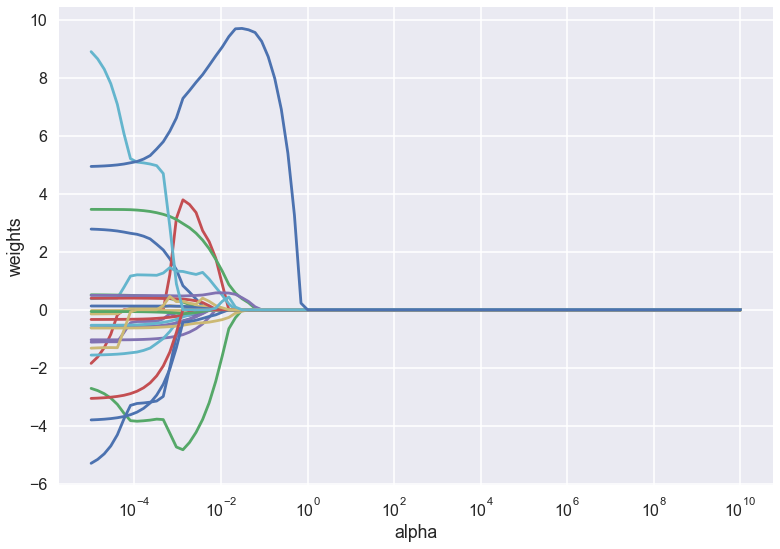

In [111]:
lasso = Lasso(max_iter=100000, normalize=True)
alphas = 10**np.linspace(10, -5, 100) * 0.5

coeffs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(quant.drop('W', axis=1)), quant['W'])
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas * 2, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

plt.show()

In [112]:
print(pd.Series(lasso.coef_, index=quant.drop(['W'], axis=1).columns))

R             2.779465
AB           -2.709652
H            -1.847430
doubles      -1.115383
triples      -0.145086
HR            0.381734
BB           -5.290970
SO            0.514519
SB            0.395286
CS           -1.035844
RA           -0.000000
ER           -1.562172
CG            0.129041
IPouts        3.458603
HA           -0.334605
HRA          -0.615526
BBA          -0.630052
SOA          -0.533616
E            -3.796065
DP           -0.062978
FP           -3.054808
attendance    0.496203
singles      -1.323275
OBP           8.893110
net_points    4.937807
dtype: float64


In [124]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(quant.drop(['R', 'W', 'net_points', 'HR'], axis=1), quant['R'])

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(quant.drop(['R', 'W', 'net_points', 'HR'], axis=1), quant['R'])
mseLasso = mean_squared_error(quant['R'], lasso.predict(quant.drop(['R', 'W', 'net_points', 'HR'], axis=1)))
coefs = pd.Series(lasso.coef_, index=quant.drop(['R', 'W', 'net_points', 'HR'], axis=1).columns)
print(coefs)
print('Lasso Test MSE: ' + str(mseLasso))

AB           -0.000000e+00
H             1.192565e+00
doubles      -6.593184e-01
triples      -3.414806e-01
BB            1.021175e-01
SO            8.280599e-03
SB            1.964090e-01
CS           -2.060985e-01
RA            6.713304e-03
ER            0.000000e+00
CG           -5.345621e-02
IPouts        1.691375e-02
HA           -2.768759e-02
HRA           1.149678e-01
BBA          -1.982491e-02
SOA          -2.389538e-02
E            -0.000000e+00
DP            5.125358e-02
FP           -6.925782e+02
attendance   -4.259266e-07
singles      -9.341055e-01
OBP           2.122167e+03
dtype: float64
Lasso Test MSE: 492.71279994


In [125]:
model = smf.ols('W~net_points+OBP+AB+BB+H+R+RA', data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     968.7
Date:                Sun, 17 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:40:22   Log-Likelihood:                -2390.5
No. Observations:                 851   AIC:                             4795.
Df Residuals:                     844   BIC:                             4828.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -164.3008    134.179     -1.224      0.221    -427.664      99.062
net_points     0.0689      0.001     48.873      0.000       0.066       0.072
OBP          904.6294    408.571      2.214      0.027     102.694    1706.564
AB             0.0378      0.022      1.706      0.088      -0.006       0.081
BB            -0.0998      0.045     -2.206      0.028      -0.189      -0.011
H             -0.1421      0.068     -2.106      0.036      -0.275      -0.010
R              0.0343      0.002     14.593      0.000       0.030       0.039
RA            -0.0347      0.002    -22.974      0.000      -0.038      -0.032
==============================================================================
Omnibus:                        1.398   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.497   Jarque-Bera (JB):                1.257
Skew:                          -0.082   Prob(JB):                        0.533
Kurtosis:                       3.091   Cond. No.                     1.57e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [126]:
mean_squared_error(model.predict(quant.drop('W', axis=1)), quant['W'])

16.122505955561454

In [127]:
model = smf.ols('W~R+RA', data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     2847.
Date:                Sun, 17 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:40:23   Log-Likelihood:                -2399.8
No. Observations:                 851   AIC:                             4806.
Df Residuals:                     848   BIC:                             4820.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     83.1820      1.457     57.090      0.000      80.322      86.042
R              0.1021      0.002     60.588      0.000       0.099       0.105
RA            -0.1051      0.002    -61.565      0.000      -0.108      -0.102
==============================================================================
Omnibus:                        1.173   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                1.066
Skew:                          -0.082   Prob(JB):                        0.587
Kurtosis:                       3.057   Cond. No.                     1.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [128]:
mean_squared_error(model.predict(quant.drop('W', axis=1)), quant['W'])

16.480754543562576

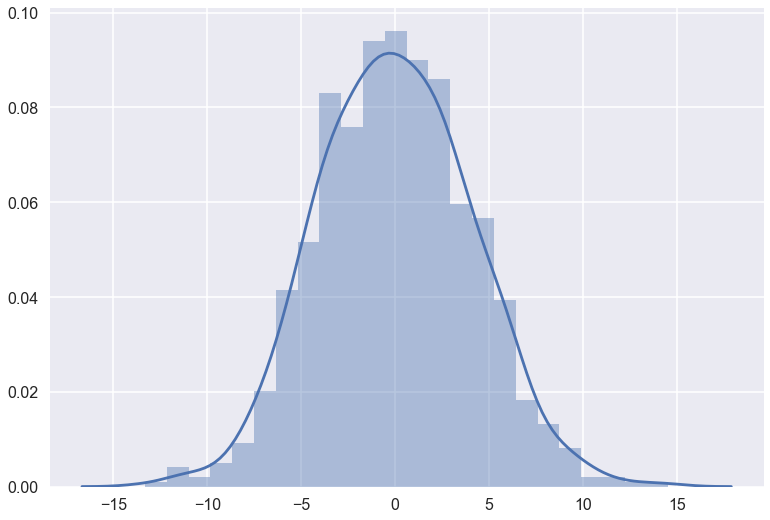

In [129]:
sns.distplot(model.predict(quant.drop('W', axis=1))-quant['W'])

In [130]:
model = smf.ols('R~OBP+AB+HR', data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      R   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     3032.
Date:                Sun, 17 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:40:25   Log-Likelihood:                -3960.4
No. Observations:                 851   AIC:                             7929.
Df Residuals:                     847   BIC:                             7948.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1489.1013     63.033    -23.624      0.000   -1612.821   -1365.382
OBP         3631.5473     73.243     49.582      0.000    3487.787    3775.307
AB             0.1629      0.013     12.799      0.000       0.138       0.188
HR             0.8761      0.025     34.805      0.000       0.827       0.926
==============================================================================
Omnibus:                        4.521   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.104   Jarque-Bera (JB):                4.504
Skew:                           0.134   Prob(JB):                        0.105
Kurtosis:                       3.234   Cond. No.                     4.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
mean_squared_error(model.predict(quant.drop('R', axis=1)), quant['R'])

645.39843477317322

In [132]:
equation = ('+').join([str(x) for x in coefs.index.values])
model = smf.ols('RA~HA+HRA+BBA+DP+E+FP', data=quant).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RA   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     1552.
Date:                Sun, 17 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:40:26   Log-Likelihood:                -3938.4
No. Observations:                 851   AIC:                             7891.
Df Residuals:                     844   BIC:                             7924.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8258.0527   1984.781      4.161      0.000    4362.368    1.22e+04
HA             0.6002      0.013     45.348      0.000       0.574       0.626
HRA            0.9167      0.038     24.129      0.000       0.842       0.991
BBA            0.3986      0.014     27.559      0.000       0.370       0.427
DP            -0.1812      0.054     -3.363      0.001      -0.287      -0.075
E             -1.0708      0.309     -3.461      0.001      -1.678      -0.464
FP         -8761.2605   1986.836     -4.410      0.000   -1.27e+04   -4861.542
==============================================================================
Omnibus:                        1.219   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.544   Jarque-Bera (JB):                1.105
Skew:                           0.005   Prob(JB):                        0.575
Kurtosis:                       3.176   Cond. No.                     5.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [133]:
mean_squared_error(model.predict(quant.drop('RA', axis=1)), quant['RA'])

612.76641664107672

In [134]:
lasso = Lasso(max_iter=100000, normalize=True)

excl = ['W', 'net_points', 'HR', 'ER', 'RA']

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(quant.drop(excl, axis=1), quant['RA'])

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(quant.drop(excl, axis=1), quant['RA'])
mseLasso = mean_squared_error(quant['RA'], lasso.predict(quant.drop(excl, axis=1)))
coefs = pd.DataFrame(lasso.coef_, index=quant.drop(excl, axis=1).columns, columns={'Beta'})
print(coefs[np.abs(coefs['Beta'])>.001])
print('Lasso Test MSE: ' + str(mseLasso))

               Beta
R          0.012364
AB         0.216994
H         -0.092113
doubles    0.085013
BB         0.068828
SO        -0.001365
SB        -0.026756
CS         0.313182
CG        -0.089357
IPouts    -0.446733
HA         0.532174
HRA        0.763634
BBA        0.365608
SOA        0.003097
E          0.283995
DP        -0.234409
FP       -74.315950
singles   -0.026132
OBP     -328.375794
Lasso Test MSE: 467.367934608
